In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

In [6]:
for train_indicies, test_indicies in split.split(df, df[["Survived", "Pclass", "Sex"]]):
    strat_train_set = df.loc[train_indicies]
    strat_test_set = df.loc[test_indicies]

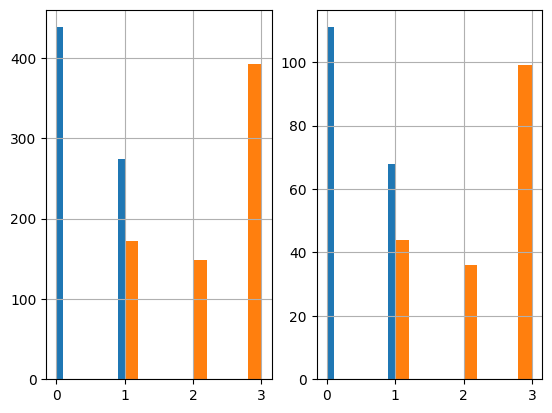

In [7]:
plt.subplot(1, 2, 1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()


plt.subplot(1, 2, 2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()
plt.show()

In [8]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 38 to 259
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          571 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        168 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [10]:
class AgeImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()
        column_names = ["C", "S", "Q", "N"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[["Sex"]]).toarray()
        column_names = ["male", "female"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

In [13]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X,y=None):
        return self

    def transform(self, X):
        return X.drop([ 'Name', 'Sex', 'Age', 'Ticket', 'Cabin', 'Embarked', "N"], axis=1, errors="ignore")

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()), 
                     ("featuredropper", FeatureDropper())])

In [16]:
strat_train_set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
38,39,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0000,NaN,S
653,654,1,3,"O'Leary, Miss. Hanora ""Norah""",female,NaN,0,0,330919,7.8292,NaN,Q
526,527,1,2,"Ridsdale, Miss. Lucy",female,50.0,0,0,W./C. 14258,10.5000,NaN,S
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C
394,395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S
...,...,...,...,...,...,...,...,...,...,...,...,...
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
143,144,0,3,"Burke, Mr. Jeremiah",male,19.0,0,0,365222,6.7500,NaN,Q
490,491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S


In [17]:
strat_train_set = pipeline.fit_transform(X=strat_train_set)

In [18]:
strat_train_set

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,C,S,Q,male,female
38,39,0,3,2,0,18.0000,0.0,0.0,1.0,1.0,0.0
653,654,1,3,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
526,527,1,2,0,0,10.5000,0.0,0.0,1.0,1.0,0.0
375,376,1,1,1,0,82.1708,1.0,0.0,0.0,1.0,0.0
394,395,1,3,0,2,16.7000,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
167,168,0,3,1,4,27.9000,0.0,0.0,1.0,1.0,0.0
143,144,0,3,0,0,6.7500,0.0,1.0,0.0,0.0,1.0
490,491,0,3,1,0,19.9667,0.0,0.0,1.0,0.0,1.0
871,872,1,1,1,1,52.5542,0.0,0.0,1.0,1.0,0.0


In [19]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 38 to 259
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   SibSp        712 non-null    int64  
 4   Parch        712 non-null    int64  
 5   Fare         712 non-null    float64
 6   C            712 non-null    float64
 7   S            712 non-null    float64
 8   Q            712 non-null    float64
 9   male         712 non-null    float64
 10  female       712 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 66.8 KB


In [20]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(["Survived"], axis=1)
y = strat_train_set["Survived"]
scaler = StandardScaler()

X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [21]:
import seaborn as sns

<Axes: >

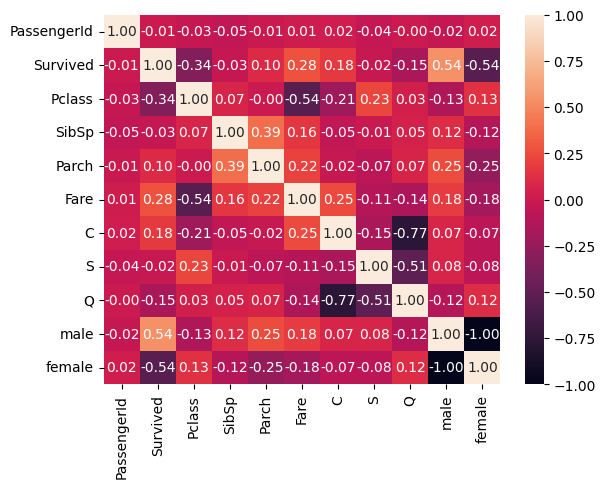

In [22]:
sns.heatmap(strat_train_set.corr(), annot=True,fmt=".2f")

**For survival** influence by Pclass, Sex, Fare

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [24]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [1e-3, 1e-2, 0.1, 1, 10],
    'kernel': ["rbf"]
}

In [25]:
model = GridSearchCV(SVC(), param_grid, cv=5)

In [26]:
model.fit(X_data, y_data)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']})

In [27]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [28]:
X_test = strat_test_set.drop(["Survived"], axis=1)
y_test = strat_test_set["Survived"]

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [29]:
model.score(X_data_test, y_data_test)

0.8044692737430168

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [32]:
forest_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)

In [33]:
forest_model.fit(X_data, y_data)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [34]:
forest_model.score(X_data_test, y_data_test)

0.7877094972067039

In [35]:
final_data = pipeline.fit_transform(df)

In [36]:
X_final = final_data.drop(["Survived"], axis=1)
y_final = final_data["Survived"]

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [37]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], 
     "min_samples_split": [2, 3, 4]}
]

prod_grid_model = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)

In [38]:
prod_grid_model.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [39]:
final_test_data = test.copy()

In [40]:
final_test_data = pipeline.fit_transform(final_test_data)

In [41]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   SibSp        418 non-null    int64  
 3   Parch        418 non-null    int64  
 4   Fare         417 non-null    float64
 5   C            418 non-null    float64
 6   S            418 non-null    float64
 7   Q            418 non-null    float64
 8   male         418 non-null    float64
 9   female       418 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 32.8 KB


In [42]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [43]:
predictions = prod_grid_model.predict(X_data_final_test)

In [44]:
final_df = pd.DataFrame(test["PassengerId"])
final_df["Survived"] = predictions

final_df.to_csv("/kaggle/working/predictions.csv", index=False)

In [45]:
final_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
